# Mod 3 Final Project

## Student Info

- Name: Steve Newman
- Cohort: 10/7/19 Part Time
- Instructor: James Irving PhD


## Instructions:

- Open and read the project assignment and guidelines in `MOD_PROJECT_README.ipynb`
- Review the hypothesis testing workflow found in this repo's `README.md` and at the bottom of the `MOD_PROJECT_README.ipynb`
- 3 functions from study group/learn.co lessons have been provided inside `functions.py`
    - `Cohen_d`, `find_outliers_IQR`,`find_outliers_Z`

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

# Questions to Answer

H1 Does discount amount have a statistically significant effect on order quantity? If so, at what level(s) of discount?

H2 Do order quantities of countries differ when discounted?

H3 Does purchase month have an effect on quantity per order?

H4 Does region have an effect on quantity per order?

In [2]:
 !pip install -U fsds_100719
 from fsds_100719.imports import *

import pandas as pd


fsds_1007219  v0.7.10 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


['[i] Pandas .iplot() method activated.']


In [3]:
from functions import Cohen_d, find_outliers_IQR,find_outliers_Z

## Uncomment the line below to see the source code for the imported functions
# fs.ihelp(Cohen_d,False),fs.ihelp(find_outliers_IQR,False), fs.ihelp(find_outliers_Z,False)

In [4]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

In [5]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


# HYPOTHESIS 1

> ***Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?***

- $H_0$: A discount does not effect the quantity of a product in an order.
- $H_1$: A discount does effect the quantity of a product in an order.

In [6]:
cur.execute("""SELECT * FROM OrderDetail """)
names = [description[0] for description in cur.description]
df_OrderDetail = pd.DataFrame(cur.fetchall(), columns = names)
df_OrderDetail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


## Determine if data is numerical or categorical

In [7]:
# Data is numerical.
# Find quantity of discounted orders by discount amount.

df_OrderDetail['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

## Determine how many groups to compare to establish which test to use.

### Two groups are being compared; use the 2 Sample T-Test.

In [8]:
# Assign 'Discounted' and 'Full Price' to 'groups' column.
# Assign '0' to 'Full Price' and '1' to 'Discounted' in the 'group_num' column.

df_OrderDetail['groups'] = df_OrderDetail['Discount'] >0 
df_OrderDetail['groups'] = df_OrderDetail['groups'].map({True:'Discounted', False:'Full Price'})
df_OrderDetail['group_num'] = df_OrderDetail['groups'].map({'Discounted':1,"Full Price": 0})

df_OrderDetail

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num
0,10248/11,10248,11,14.00,12,0.00,Full Price,0
1,10248/42,10248,42,9.80,10,0.00,Full Price,0
2,10248/72,10248,72,34.80,5,0.00,Full Price,0
3,10249/14,10249,14,18.60,9,0.00,Full Price,0
4,10249/51,10249,51,42.40,40,0.00,Full Price,0
...,...,...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03,Discounted,1
2151,11077/66,11077,66,17.00,1,0.00,Full Price,0
2152,11077/73,11077,73,15.00,2,0.01,Discounted,1
2153,11077/75,11077,75,7.75,4,0.00,Full Price,0


### Check data to see if it meets test assumptions.

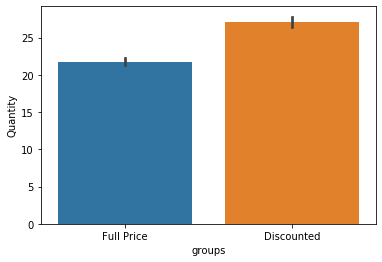

In [9]:
# View barplot to see if the categories are statistically different and compare standard error of the mean.
# Discounted products sold in larger quantities.

sns.barplot(data=df_OrderDetail, x='groups', y='Quantity', ci=68 )

In [10]:
# Create 'grps' dictionary to seperate 'quantity' into 'Full Price' and 'Discounted' categories.

grps = {}
for grp_name in df_OrderDetail['groups'].unique():
    grps[grp_name] = df_OrderDetail.groupby('groups').get_group(grp_name)['Quantity']
grps

{'Full Price': 0       12
 1       10
 2        5
 3        9
 4       40
         ..
 2147     2
 2148     2
 2151     1
 2153     4
 2154     2
 Name: Quantity, Length: 1317, dtype: int64, 'Discounted': 6       35
 7       15
 8        6
 9       15
 11      40
         ..
 2144     2
 2146     3
 2149     2
 2150     2
 2152     2
 Name: Quantity, Length: 838, dtype: int64}

### Check for outliers.

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Total Ordered by Discounted and Full Price Group')]

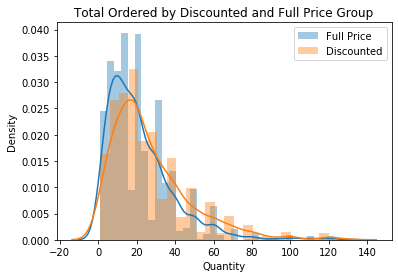

In [11]:
# Show Distribution Plot of both groups to determine if normailty assumption is met.

for grp_name,grp_data in grps.items():
    sns.distplot(grp_data,label=grp_name)
    
    
ax= plt.gca()
ax.legend()
ax.set(title='Total Ordered by Discounted and Full Price Group', ylabel='Density')

In [12]:
orig_grps = grps.copy()

In [13]:
# Identify how many outliers found in each group using Z-Scores and IQR.

for grp_name, grp_data in grps.items():
    idx_outs =find_outliers_Z(grp_data)
    print(f"Found {idx_outs.sum()} outliers in {grp_name} using Z-scores")
    grps[grp_name] = grp_data [~idx_outs]
    idx_outs =find_outliers_IQR(grp_data)

    print(f"Found {idx_outs.sum()} outliers in {grp_name} using IQR")
    print('\n')

Found 20 outliers in Full Price using Z-scores
Found 34 outliers in Full Price using IQR


Found 15 outliers in Discounted using Z-scores
Found 29 outliers in Discounted using IQR




In [14]:
# Remove outliers.

grp_data [~idx_outs]

6       35
7       15
8        6
9       15
11      40
        ..
2144     2
2146     3
2149     2
2150     2
2152     2
Name: Quantity, Length: 809, dtype: int64

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Total Quantity for Full Price vs Discounted Products')]

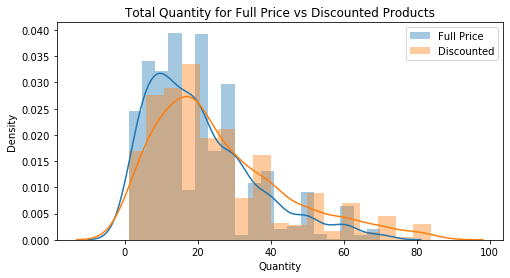

In [15]:
# Check for normality after removing outliers.

fig,ax=plt.subplots(figsize=(8,4))
for grp_name,grp_data in grps.items():
    sns.distplot(grp_data,label=grp_name, ax=ax)
    
    
ax.legend()
ax.set(title='Total Quantity for Full Price vs Discounted Products', ylabel='Density')

### Confirm normality with scipy normal test.

In [16]:
import scipy.stats as stats

In [17]:
for k,v in grps.items():
    stat,p = stats.normaltest(v)
    print(f"Group {k} Normaltest p-value = {round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'
    print(f"\t-The data is {sig} normal.")

Group Full Price Normaltest p-value = 0.0
	-The data is is NOT normal.
Group Discounted Normaltest p-value = 0.0
	-The data is is NOT normal.


In [18]:
# Failed normality test; check sample sizes to see if large enough to bypass normality assumption.


In [19]:
# Each group is greater than 15; safe to ignore normality assumption.

len(grps['Full Price']), len(grps['Discounted'])

(1297, 823)

## Check for equal variance.

In [20]:
# Prepare data for levene test to check for equal variance.

data = []
for k,v in grps.items():
    data.append(v)
data[0]

0       12
1       10
2        5
3        9
4       40
        ..
2147     2
2148     2
2151     1
2153     4
2154     2
Name: Quantity, Length: 1297, dtype: int64

In [21]:
stats.levene(data[0],data[1])

LeveneResult(statistic=19.187113832590878, pvalue=1.2429073348187694e-05)

In [22]:
# Does not pass Levene test.

stat, p = stats.levene(*data)
print(f"Levene' Test for Equal Variance p-value={round(p,4)}")
sig = 'do NOT' if p<.05 else 'DO'

print(f"\t- The groups {sig} have equal variance.")

Levene' Test for Equal Variance p-value=0.0
	- The groups do NOT have equal variance.


In [23]:
# Test using alternative Welch's T-Test for equal variance.
# P value is less than 0.05; reject null hypothesis that the groups have identical average values.

stat,p = stats.ttest_ind(grps['Full Price'], grps['Discounted'], equal_var=False)
print(f"Welch's t-test p value={round(p,4)}")

Welch's t-test p value=0.0


In [24]:
# Check for effect size.
# Effect size is small, indicating the difference in means is trivial.
Cohen_d(grps['Full Price'],grps['Discounted'])

-0.32001140965727837

In [25]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model = pairwise_tukeyhsd(df_OrderDetail['Quantity'],df_OrderDetail['Discount'])
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
0.0,0.05,6.2955,0.0011,1.5381,11.053,True
0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
0.0,0.15,6.6669,0.0014,1.551,11.7828,True
0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
0.0,0.25,6.525,0.0023,1.3647,11.6852,True


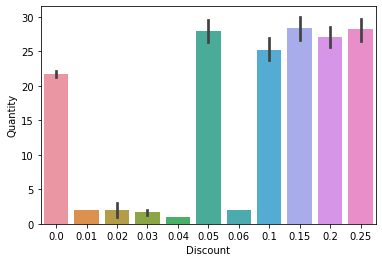

In [26]:
sns.barplot(data=df_OrderDetail,x='Discount',y='Quantity',ci=68)

## Conclusion

The null hypothesis is rejected. A discount does effect the quantity of a product in an order. A 5%, 10%, 15%, 20%, and 25% discount all increase order quantity from not offering any discount. Interstingly, a 5% discount appears to match or in some cases increase quantity sold compared to all other discounts. It is reccomended to offer a 5% discount and not offer the other discounts in order to save revenue.

# HYPOTHESIS 2

> ***Do order quantities of different countries differ when discounted?***

- $H_0$: Order quantities of different countries are the same when discounted.
- $H_1$: Order quantities of different countries are not the same when discounted.

In [28]:
cur.execute("""SELECT * FROM 'Order'""")
names = [description[0] for description in cur.description]
df_order = pd.DataFrame(cur.fetchall(), columns = names)
df_order.head()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [29]:
df_OrderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num
0,10248/11,10248,11,14.0,12,0.0,Full Price,0
1,10248/42,10248,42,9.8,10,0.0,Full Price,0
2,10248/72,10248,72,34.8,5,0.0,Full Price,0
3,10249/14,10249,14,18.6,9,0.0,Full Price,0
4,10249/51,10249,51,42.4,40,0.0,Full Price,0


In [30]:
# Prepare df_order to merge with df_OrderDetail
df_order.rename({'Id':'OrderId'}, axis=1, inplace=True)
df_order.head()

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [31]:
df_merge = df_OrderDetail.merge(df_order, on='OrderId', copy=True)
df_merge.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num,CustomerId,EmployeeId,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,Full Price,0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,Full Price,0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,Full Price,0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,Full Price,0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,Full Price,0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


## Determine if data is numerical or categorical

In [32]:
# Data is numerical.
# Find quantity of orders by country.

df_countries = df_merge[df_merge['group_num'] == 1][['ShipCountry', 'Quantity']].groupby(['ShipCountry']).sum()

df_countries.head()

,Quantity
ShipCountry,
Austria,2504
Belgium,410
Brazil,1898
Canada,1073
Denmark,475


In [33]:
# Create df_ctry for discounted quantities.
df_ctry = df_merge[df_merge['group_num'] == 1][['ShipCountry', 'Quantity']]

## Determine how many groups to compare to establish which test to use.

### More than two groups are being compared; use the ANOVA or Tukey test.

### Check data to see if it meets test assumptions.

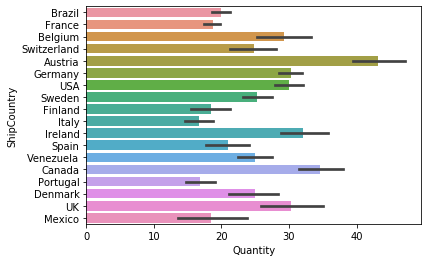

In [43]:
# View barplot to see if the categories are statistically different and compare standard error of the mean.
# Many countries bought discounted products in different quantities.
sns.barplot(data=df_ctry, x='Quantity', y='ShipCountry', ci=68,)

### Check for outliers.

In [44]:
# Create 'grps' dictionary to seperate 'countries' by 'quantity'.
grps = {}
for grp_name in df_ctry['ShipCountry'].unique():
    grps[grp_name] = df_ctry.groupby('ShipCountry').get_group(grp_name)['Quantity']
grps

{'Brazil': 6       35
 7       15
 104     40
 106     15
 115     20
         ..
 2067    30
 2068    10
 2107     8
 2108    36
 2109    28
 Name: Quantity, Length: 95, dtype: int64, 'France': 8        6
 9       15
 246     20
 247     12
 248     40
         ..
 1779    20
 2066    10
 2127    20
 2128    20
 2129    10
 Name: Quantity, Length: 77, dtype: int64, 'Belgium': 11      40
 12      25
 604     35
 605     60
 606     42
 1350    12
 1352    30
 1683    40
 1772    25
 1773    30
 1882    20
 1883    40
 1885     6
 2041     5
 Name: Quantity, dtype: int64, 'Switzerland': 17      15
 18      21
 326     15
 328     20
 457     60
 458     20
 715     16
 717     10
 1276    40
 1277    30
 1325    12
 1327    20
 1774    42
 1822    15
 1823     6
 1824    50
 1859    12
 1860    12
 2029    70
 2030    36
 2049    30
 2124    10
 2125    30
 2126     2
 Name: Quantity, dtype: int64, 'Austria': 29       50
 30       65
 31        6
 43       60
 45       60
 46       36
 

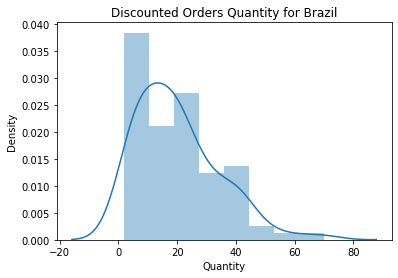

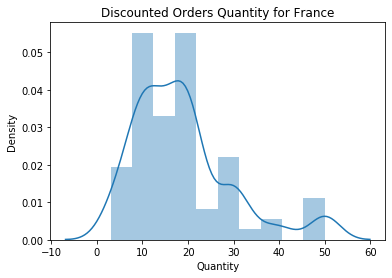

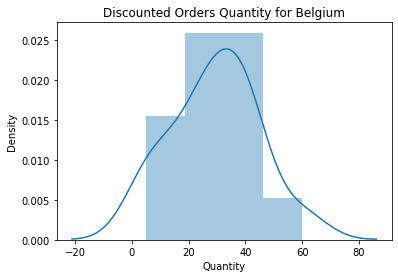

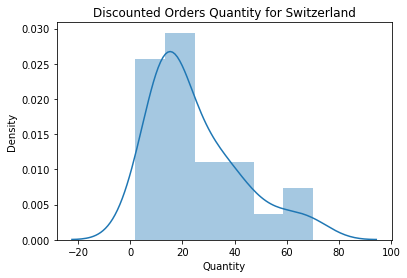

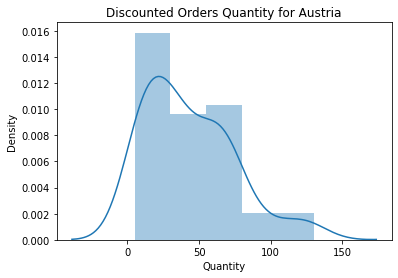

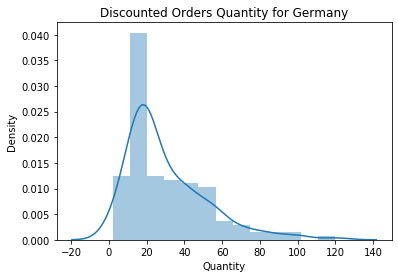

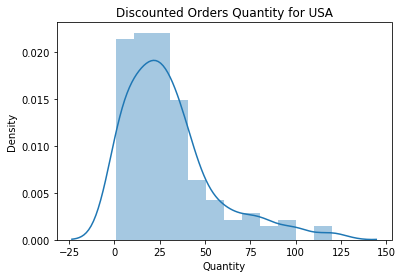

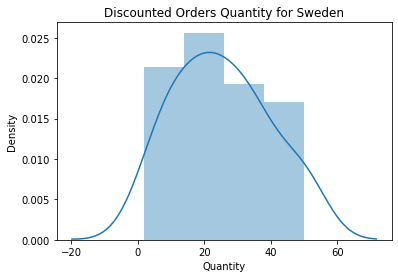

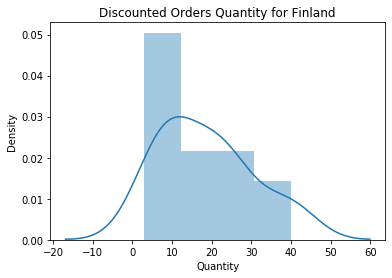

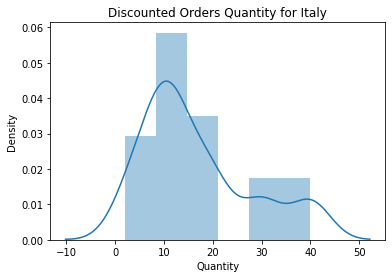

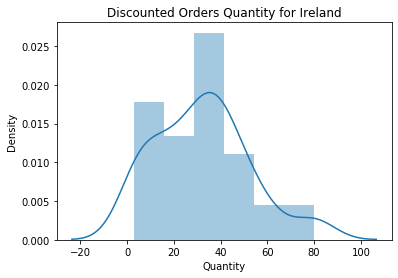

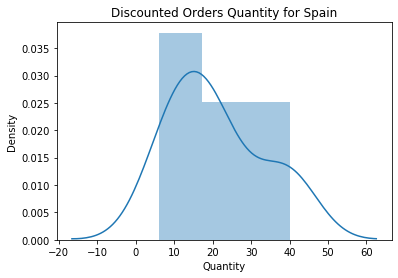

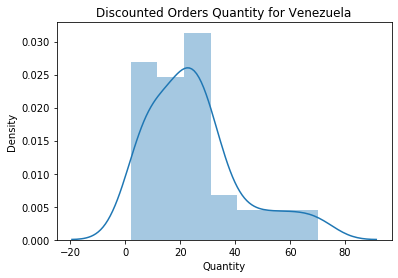

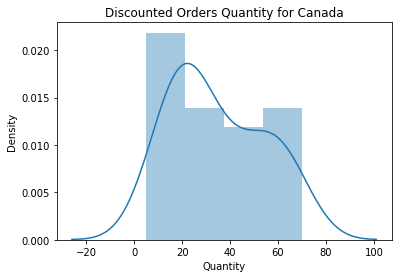

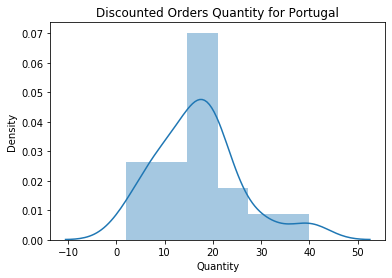

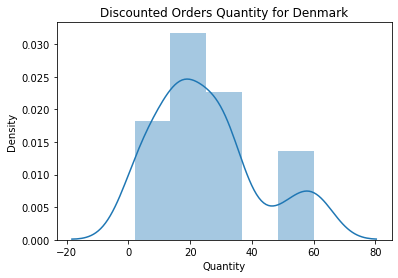

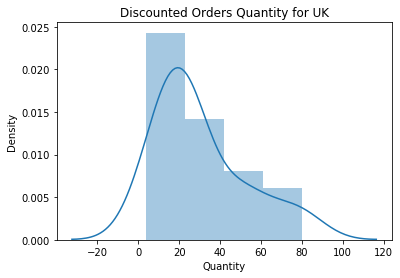

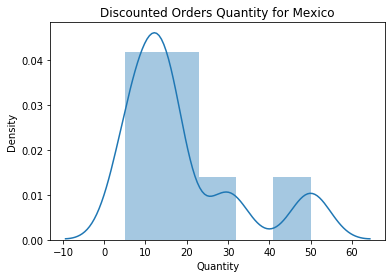

In [49]:
# Show Distribution Plot of Discounted group to determine if normailty assumption is met.
for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Discounted Orders Quantity for {grp_name}', ylabel='Density')

In [13]:
orig_grps = grps.copy()

In [50]:
# Identify how many outliers found in each group using Z-Scores.

for grp_name, grp_data in grps.items():
    idx_outs =find_outliers_Z(grp_data)
    print(f"Found {idx_outs.sum()} outliers in {grp_name} using Z-scores")
    grps[grp_name] = grp_data [~idx_outs]
    idx_outs =find_outliers_IQR(grp_data)

Found 1 outliers in Brazil using Z-scores


Found 0 outliers in France using Z-scores


Found 0 outliers in Belgium using Z-scores


Found 0 outliers in Switzerland using Z-scores


Found 0 outliers in Austria using Z-scores


Found 3 outliers in Germany using Z-scores


Found 2 outliers in USA using Z-scores


Found 0 outliers in Sweden using Z-scores


Found 0 outliers in Finland using Z-scores


Found 0 outliers in Italy using Z-scores


Found 0 outliers in Ireland using Z-scores


Found 0 outliers in Spain using Z-scores


Found 0 outliers in Venezuela using Z-scores


Found 0 outliers in Canada using Z-scores


Found 0 outliers in Portugal using Z-scores


Found 0 outliers in Denmark using Z-scores


Found 0 outliers in UK using Z-scores


Found 0 outliers in Mexico using Z-scores




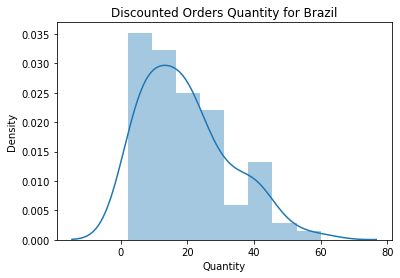

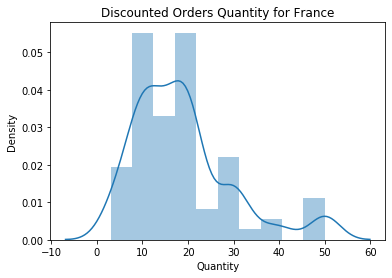

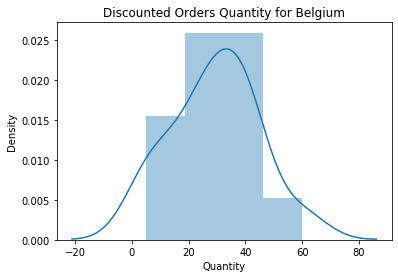

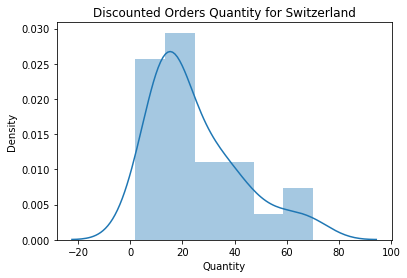

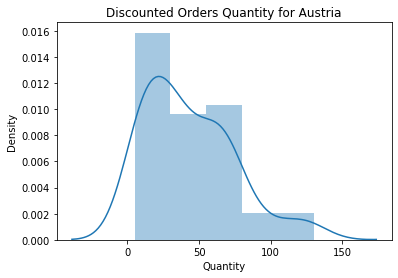

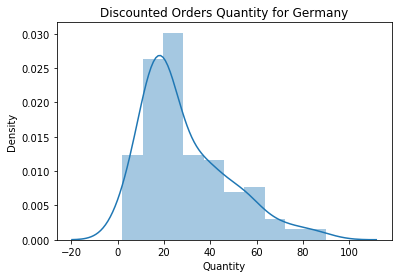

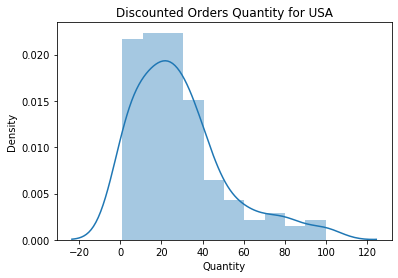

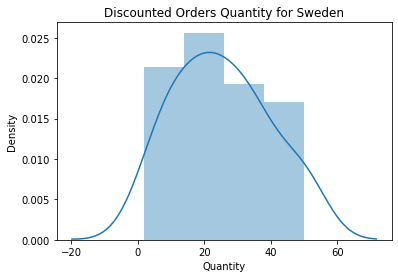

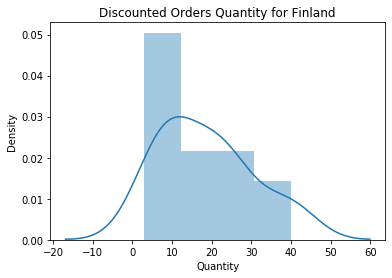

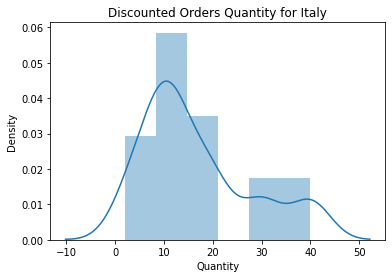

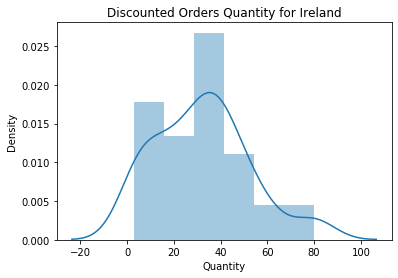

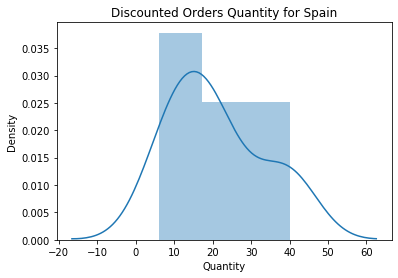

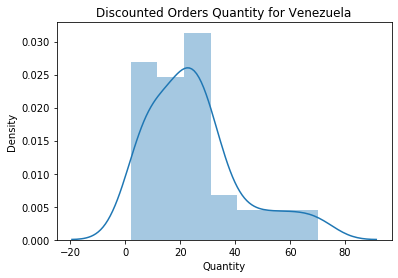

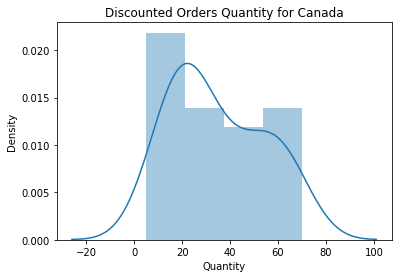

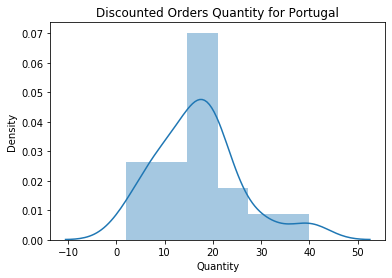

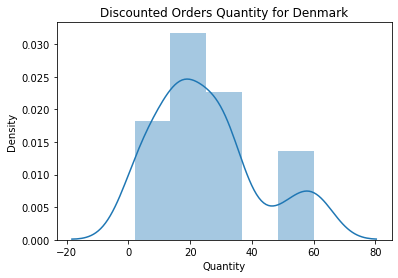

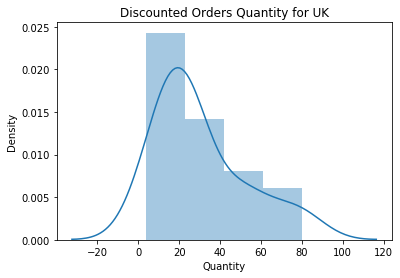

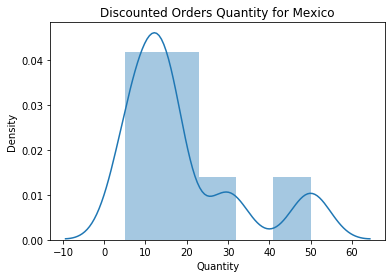

In [51]:
# Show Distribution Plot of Discounted group to determine if normailty assumption is met.
for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Discounted Orders Quantity for {grp_name}', ylabel='Density')

### Confirm normality with scipy normal test.

In [17]:
import scipy.stats as stats

In [57]:
for k,v in grps.items():
    stat,p = stats.normaltest(v)
    print(f"Group {k} Normaltest p-value = {round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'
    print(f"\t-The data is {sig} normal.")
    print(f"Group {k} sample size = {len(v)}")
    size = 'CAN' if len(v)>20 else 'CAN NOT'
    print(f"\t-Normality assumption {size} be ignored.")
    print('\n')

Group Brazil Normaltest p-value = 0.0002
	-The data is is NOT normal.
Group Brazil sample size = 95
	-Normality assumption CAN be ignored.


Group France Normaltest p-value = 0.0001
	-The data is is NOT normal.
Group France sample size = 77
	-Normality assumption CAN be ignored.


Group Belgium Normaltest p-value = 0.9793
	-The data is IS normal.
Group Belgium sample size = 14
	-Normality assumption CAN NOT be ignored.


Group Switzerland Normaltest p-value = 0.0339
	-The data is is NOT normal.
Group Switzerland sample size = 24
	-Normality assumption CAN be ignored.


Group Austria Normaltest p-value = 0.0182
	-The data is is NOT normal.
Group Austria sample size = 58
	-Normality assumption CAN be ignored.


Group Germany Normaltest p-value = 0.0
	-The data is is NOT normal.
Group Germany sample size = 150
	-Normality assumption CAN be ignored.


Group USA Normaltest p-value = 0.0
	-The data is is NOT normal.
Group USA sample size = 142
	-Normality assumption CAN be ignored.


Group S

In [19]:
# Failed normality testand sample sizes are not large enough to bypass normality assumption.


In [55]:
# Prepare data for  to check for equal variance.

data = []
for k,v in grps.items():
    data.append(v)
data[0]

6       35
7       15
104     40
106     15
115     20
        ..
2067    30
2068    10
2107     8
2108    36
2109    28
Name: Quantity, Length: 94, dtype: int64

In [57]:
stats.kruskal(*data)

KruskalResult(statistic=73.94483142717863, pvalue=4.466630803214601e-09)

In [ ]:
# Kruskal test result is p-value is less than .05, null hypothesis is rejected. 

In [62]:
import functions as fn
data = fn.prep_data_for_tukeys(grps)
data

,data,group
6,35.0,Brazil
7,15.0,Brazil
104,40.0,Brazil
106,15.0,Brazil
115,20.0,Brazil
...,...,...
762,10.0,Mexico
763,5.0,Mexico
764,15.0,Mexico
1127,30.0,Mexico


In [63]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model = pairwise_tukeyhsd(data['data'],data['group'])
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Austria,Belgium,-13.8867,0.5329,-33.4055,5.6321,False
Austria,Brazil,-23.7256,0.001,-34.6704,-12.7808,True
Austria,Canada,-8.5595,0.8166,-23.1431,6.0241,False
Austria,Denmark,-18.1724,0.0285,-35.4993,-0.8456,True
Austria,Finland,-24.7057,0.001,-43.6932,-5.7183,True
Austria,France,-24.4971,0.001,-35.8936,-13.1006,True
Austria,Germany,-14.4377,0.001,-24.6018,-4.2736,True
Austria,Ireland,-11.0296,0.348,-25.0596,3.0005,False
Austria,Italy,-26.5057,0.001,-41.7771,-11.2343,True
Austria,Mexico,-24.6724,0.0511,-49.3941,0.0493,False


In [64]:
df = pd.DataFrame(data=model._results_table.data[1:], columns=model._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Austria,Belgium,-13.8867,0.5329,-33.4055,5.6321,False
1,Austria,Brazil,-23.7256,0.0010,-34.6704,-12.7808,True
2,Austria,Canada,-8.5595,0.8166,-23.1431,6.0241,False
3,Austria,Denmark,-18.1724,0.0285,-35.4993,-0.8456,True
4,Austria,Finland,-24.7057,0.0010,-43.6932,-5.7183,True
...,...,...,...,...,...,...,...
148,Switzerland,USA,3.9929,0.9000,-10.4888,18.4745,False
149,Switzerland,Venezuela,0.2283,0.9000,-16.2773,16.7338,False
150,UK,USA,-1.4879,0.9000,-15.4860,12.5102,False
151,UK,Venezuela,-5.2525,0.9000,-21.3355,10.8305,False


In [77]:
df_grp12p = df[df['reject'] == True][['group1', 'group2','p-adj']]
df_grp12p.reset_index(drop=True, inplace= True)
df_grp12p

,group1,group2,p-adj
0,Austria,Brazil,0.0010
1,Austria,Denmark,0.0285
2,Austria,Finland,0.0010
3,Austria,France,0.0010
4,Austria,Germany,0.0010
5,Austria,Italy,0.0010
6,Austria,Portugal,0.0010
7,Austria,Spain,0.0089
8,Austria,Sweden,0.0010
9,Austria,Switzerland,0.0070


In [78]:
df_grp12p.to_csv("pvalues2.csv")

In [66]:
pd.set_option("display.max_rows",999)

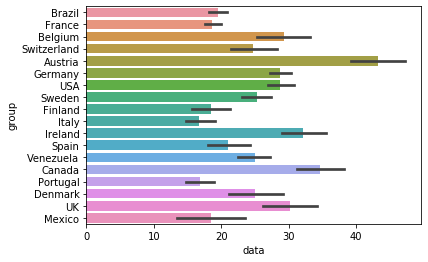

In [70]:
sns.barplot(data=data ,x='data',y='group',ci=68)

# Conclusion

The null hypothesis is rejected. Order quantities of different countries are not the same when discounted. It appears that Austria's order quantity is greater than 11 countries. Brazil is different from Canada, Germany, and USA. Canada is different from France and Italy and France is different from Germany, Ireland, and USA.

# HYPOTHESIS 3

> ***Does purchase month have an effect on quantity per order?***

- $H_0$: Purchase month does not have an effect on quantity per an order.
- $H_1$: Purchase month does have an effect on quantity per an order.

In [34]:
df_merge

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num,CustomerId,EmployeeId,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.00,12,0.00,Full Price,0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.80,10,0.00,Full Price,0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.80,5,0.00,Full Price,0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.60,9,0.00,Full Price,0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.40,40,0.00,Full Price,0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03,Discounted,1,RATTC,1,...,2014-06-03,None,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA
2151,11077/66,11077,66,17.00,1,0.00,Full Price,0,RATTC,1,...,2014-06-03,None,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA
2152,11077/73,11077,73,15.00,2,0.01,Discounted,1,RATTC,1,...,2014-06-03,None,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA
2153,11077/75,11077,75,7.75,4,0.00,Full Price,0,RATTC,1,...,2014-06-03,None,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA


## Determine if data is numerical or categorical

In [35]:
# Data is numerical.
# Find quantity of discounted orders by discount amount.


pd.to_datetime(df_merge['OrderDate'], format='%Y/%m/%d').head()

0   2012-07-04
1   2012-07-04
2   2012-07-04
3   2012-07-05
4   2012-07-05
Name: OrderDate, dtype: datetime64[ns]

In [36]:
df_merge['OrderMonth'] = pd.DatetimeIndex(df_merge['OrderDate']).month
df_merge['OrderYear'] = pd.DatetimeIndex(df_merge['OrderDate']).year
df_merge.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num,CustomerId,EmployeeId,...,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,OrderMonth,OrderYear
0,10248/11,10248,11,14.0,12,0.0,Full Price,0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
1,10248/42,10248,42,9.8,10,0.0,Full Price,0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
2,10248/72,10248,72,34.8,5,0.0,Full Price,0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
3,10249/14,10249,14,18.6,9,0.0,Full Price,0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012
4,10249/51,10249,51,42.4,40,0.0,Full Price,0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012


## Determine how many groups to compare to establish which test to use.

### More than two groups are being compared; use the ANOVA test.

### Check data to see if it meets test assumptions.

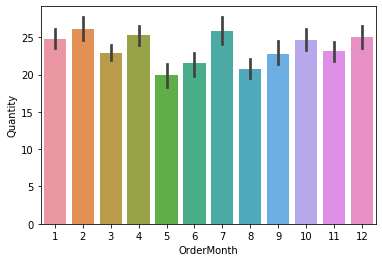

In [39]:
# View barplot to see if the categories are statistically different and compare standard error of the mean.
# Discounted products sold in larger quantities.

sns.barplot(data=df_merge, x='OrderMonth', y='Quantity', ci=68 )

In [40]:
# Create 'grps' dictionary to seperate 'quantity' into 'OrderMonth' categories.

grps = {}
for grp_name in df_merge['OrderMonth'].unique():
    grps[grp_name] = df_merge.groupby('OrderMonth').get_group(grp_name)['Quantity']
grps

{7: 0      12
 1      10
 2       5
 3       9
 4      40
        ..
 971    15
 972    14
 973    15
 974    15
 975    30
 Name: Quantity, Length: 136, dtype: int64, 8: 59      30
 60      25
 61      24
 62       6
 63      40
         ..
 1055    20
 1056    15
 1057    30
 1058    25
 1059    30
 Name: Quantity, Length: 153, dtype: int64, 9: 128      4
 129     12
 130     30
 131     15
 132     60
         ..
 1150    30
 1151    15
 1152    50
 1153    10
 1154     6
 Name: Quantity, Length: 152, dtype: int64, 10: 185     20
 186      6
 187      8
 188     14
 189     30
         ..
 1256    16
 1257     5
 1258    12
 1259     4
 1260     6
 Name: Quantity, Length: 179, dtype: int64, 11: 258     35
 259     70
 260     70
 261     80
 262      9
         ..
 1345    24
 1346    20
 1347    60
 1348    40
 1349    10
 Name: Quantity, Length: 155, dtype: int64, 12: 324     20
 325     18
 326     15
 327     30
 328     20
         ..
 1459    10
 1460    20
 1461     2
 1462  

### Check for outliers.

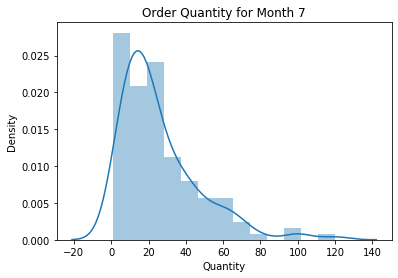

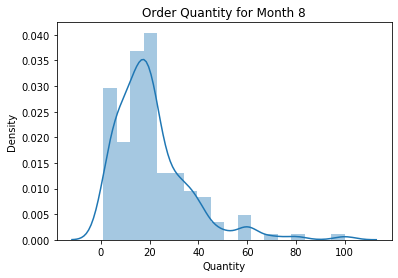

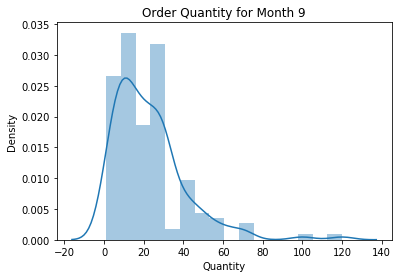

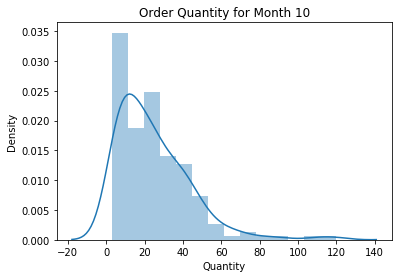

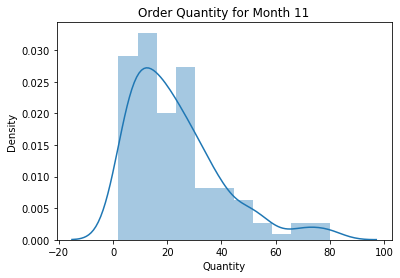

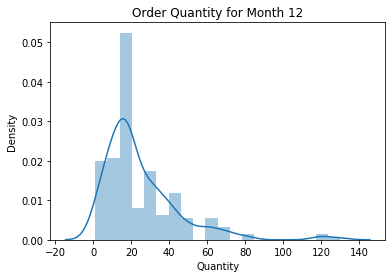

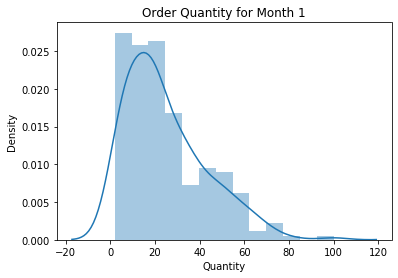

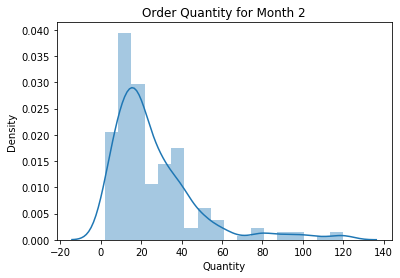

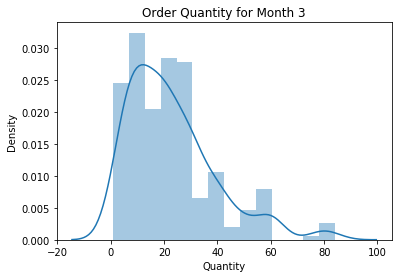

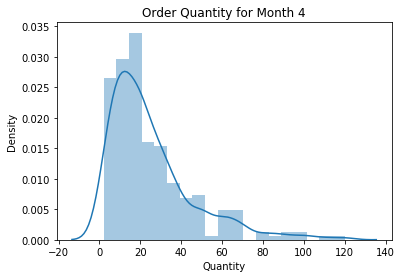

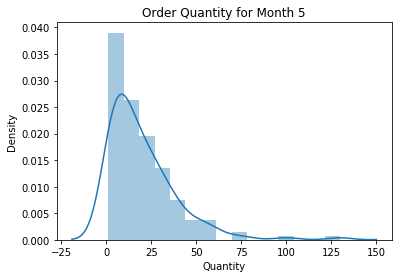

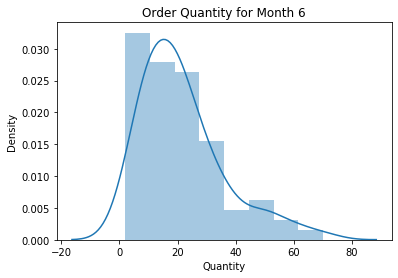

In [42]:
# Show Distribution Plot of Discounted group to determine if normailty assumption is met.
for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Order Quantity for Month {grp_name}', ylabel='Density')

In [13]:
orig_grps = grps.copy()

In [43]:
# Identify how many outliers found in each group using Z-Scores.

for grp_name, grp_data in grps.items():
    idx_outs =find_outliers_Z(grp_data)
    print(f"Found {idx_outs.sum()} outliers in {grp_name} using Z-scores")
    grps[grp_name] = grp_data [~idx_outs]
    idx_outs =find_outliers_IQR(grp_data)

Found 3 outliers in 7 using Z-scores
Found 3 outliers in 8 using Z-scores
Found 2 outliers in 9 using Z-scores
Found 3 outliers in 10 using Z-scores
Found 3 outliers in 11 using Z-scores
Found 3 outliers in 12 using Z-scores
Found 2 outliers in 1 using Z-scores
Found 6 outliers in 2 using Z-scores
Found 5 outliers in 3 using Z-scores
Found 6 outliers in 4 using Z-scores
Found 2 outliers in 5 using Z-scores
Found 1 outliers in 6 using Z-scores


In [44]:
# Remove outliers.

grp_data [~idx_outs]

823    30
824    35
825    18
826    20
827    40
       ..
894    14
895    10
896    24
897    10
898    50
Name: Quantity, Length: 73, dtype: int64

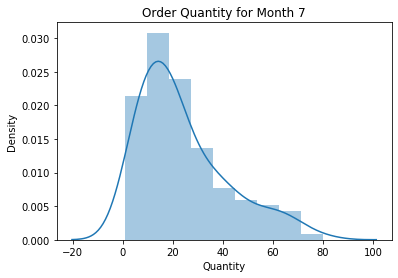

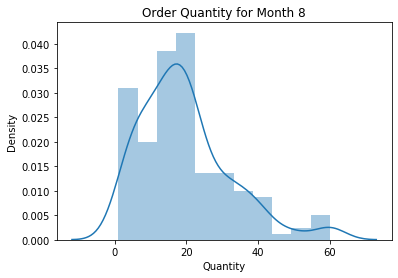

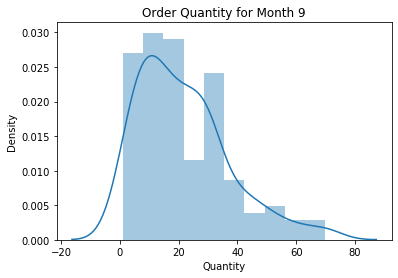

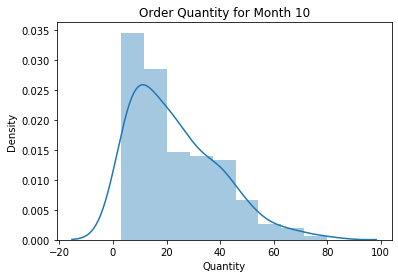

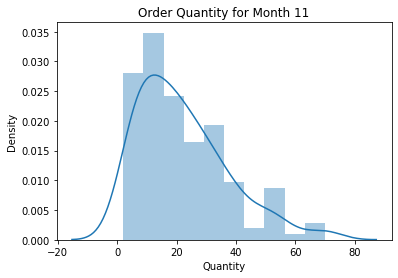

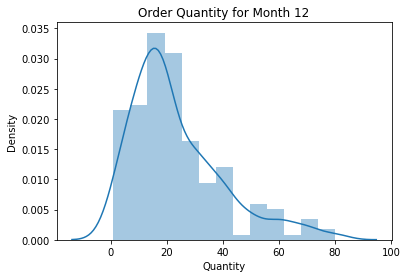

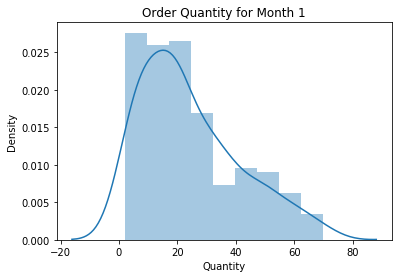

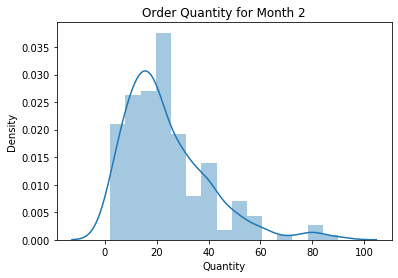

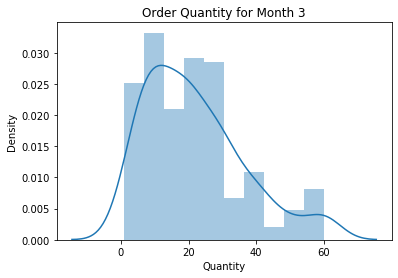

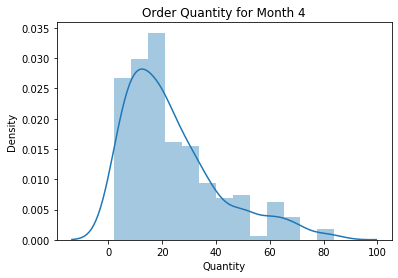

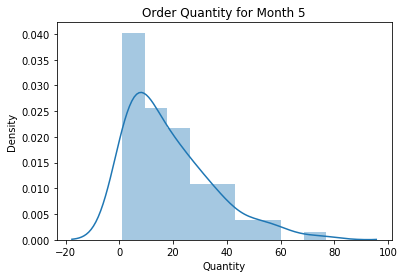

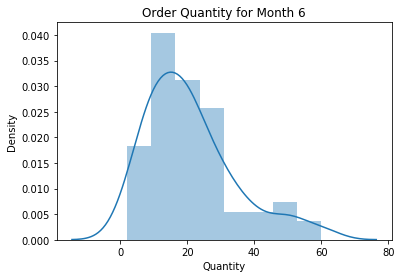

In [45]:
# Check for normality after removing outliers.

for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Order Quantity for Month {grp_name}', ylabel='Density')

### Confirm normality with scipy normal test.

In [46]:
import scipy.stats as stats

In [19]:
# Failed normality test; check sample sizes to see if large enough to bypass normality assumption.
# Each group is greater than 15; safe to ignore normality assumption.

In [48]:
for k,v in grps.items():
    stat,p = stats.normaltest(v)
    print(f"Group {k} Normaltest p-value = {round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'
    print(f"\t-The data is {sig} normal.")
    print(f"Group {k} sample size = {len(v)}")
    size = 'CAN' if len(v)>20 else 'CAN NOT'
    print(f"\t-Normality assumption {size} be ignored.")
    print('\n')

Group 7 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 7 sample size = 133
	-Normality assumption CAN be ignored.


Group 8 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 8 sample size = 150
	-Normality assumption CAN be ignored.


Group 9 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 9 sample size = 150
	-Normality assumption CAN be ignored.


Group 10 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 10 sample size = 176
	-Normality assumption CAN be ignored.


Group 11 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 11 sample size = 152
	-Normality assumption CAN be ignored.


Group 12 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 12 sample size = 192
	-Normality assumption CAN be ignored.


Group 1 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 1 sample size = 235
	-Normality assumption CAN be ignored.


Group 2 Normaltest p-value = 0.0
	-The data is is NOT normal.
Group 2 sample size = 195
	-N

## Check for equal variance.

In [51]:
# Prepare data for levene test to check for equal variance.

data = []
for k,v in grps.items():
    data.append(v)
data[0]

0      12
1      10
2       5
3       9
4      40
       ..
971    15
972    14
973    15
974    15
975    30
Name: Quantity, Length: 133, dtype: int64

In [53]:
stats.levene(*data)

LeveneResult(statistic=1.7808651012328485, pvalue=0.05205448579357027)

In [54]:
# Does pass Levene test.

stat, p = stats.levene(*data)
print(f"Levene' Test for Equal Variance p-value={round(p,4)}")
sig = 'do NOT' if p<.05 else 'DO'

print(f"\t- The groups {sig} have equal variance.")

Levene' Test for Equal Variance p-value=0.0521
	- The groups DO have equal variance.


In [57]:
# P value is less than 0.05; reject null hypothesis that month does not have an effect on quantity per an order.

stat,p = stats.f_oneway(*data)
print(f"One-Way ANOVA p-value={round(p,4)}")

One-Way ANOVA p-value=0.0204


In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model = pairwise_tukeyhsd(df_merge['OrderMonth'],df_merge['Quantity'])
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-1.0452,0.9,-5.1597,3.0692,False
1,3,-0.179,0.9,-4.359,4.001,False
1,4,-0.0984,0.9,-4.1851,3.9883,False
1,5,-0.2783,0.9,-4.2776,3.721,False
1,6,-0.261,0.9,-4.1662,3.6442,False
1,7,0.6036,0.9,-4.1067,5.3139,False
1,8,-0.3129,0.9,-4.4476,3.8217,False
1,9,-0.3863,0.9,-4.857,4.0844,False
1,10,-0.3474,0.9,-4.0832,3.3883,False
1,11,-1.3529,0.9,-12.3619,9.656,False


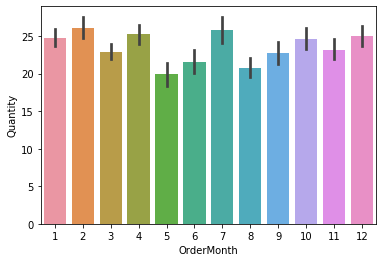

In [59]:
sns.barplot(data=df_merge,x='OrderMonth',y='Quantity',ci=68)

# Conclusion

# HYPOTHESIS 4

> ***Does region have an effect on quantity per order?***

- $H_0$: Region does not effect the quantity of a product in an order.
- $H_1$: Region does effect the quantity of a product in an order.

In [67]:
df_merge

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num,CustomerId,EmployeeId,...,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,OrderMonth,OrderYear
0,10248/11,10248,11,14.00,12,0.00,Full Price,0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
1,10248/42,10248,42,9.80,10,0.00,Full Price,0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
2,10248/72,10248,72,34.80,5,0.00,Full Price,0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
3,10249/14,10249,14,18.60,9,0.00,Full Price,0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012
4,10249/51,10249,51,42.40,40,0.00,Full Price,0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03,Discounted,1,RATTC,1,...,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA,5,2014
2151,11077/66,11077,66,17.00,1,0.00,Full Price,0,RATTC,1,...,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA,5,2014
2152,11077/73,11077,73,15.00,2,0.01,Discounted,1,RATTC,1,...,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA,5,2014
2153,11077/75,11077,75,7.75,4,0.00,Full Price,0,RATTC,1,...,2,8.53,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA,5,2014


In [74]:
cur.execute("""SELECT Id, Region FROM Customer """)
names = [description[0] for description in cur.description]
df_Customer = pd.DataFrame(cur.fetchall(), columns = names)
df_Customer

,Id,Region
0,ALFKI,Western Europe
1,ANATR,Central America
2,ANTON,Central America
3,AROUT,British Isles
4,BERGS,Northern Europe
...,...,...
86,WARTH,Scandinavia
87,WELLI,South America
88,WHITC,North America
89,WILMK,Scandinavia


In [75]:
# Prepare df_Customer to merge with df_merge
df_Customer.rename({'Id':'CustomerId'}, axis=1, inplace=True)
df_Customer.head()

,CustomerId,Region
0,ALFKI,Western Europe
1,ANATR,Central America
2,ANTON,Central America
3,AROUT,British Isles
4,BERGS,Northern Europe


In [77]:
df_Region = df_merge.merge(df_Customer, on='CustomerId', copy=True)
df_Region.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,groups,group_num,CustomerId,EmployeeId,...,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,OrderMonth,OrderYear,Region
0,10248/11,10248,11,14.0,12,0.0,Full Price,0,VINET,5,...,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012,Western Europe
1,10248/42,10248,42,9.8,10,0.0,Full Price,0,VINET,5,...,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012,Western Europe
2,10248/72,10248,72,34.8,5,0.0,Full Price,0,VINET,5,...,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012,Western Europe
3,10274/71,10274,71,17.2,20,0.0,Full Price,0,VINET,6,...,6.01,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,8,2012,Western Europe
4,10274/72,10274,72,27.8,7,0.0,Full Price,0,VINET,6,...,6.01,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,8,2012,Western Europe


## Determine if data is numerical or categorical

In [84]:
# Data is numerical.
# Find quantity of orders by region.

df_RegionQty = df_Region[df_Region[['Region', 'Quantity']].groupby(['Region']).sum()
df_RegionQty


SyntaxError: invalid syntax (<ipython-input-84-8856d58c628a>, line 5)

## Determine how many groups to compare to establish which test to use.

### Two groups are being compared; use the 2 Sample T-Test.

### Check data to see if it meets test assumptions.

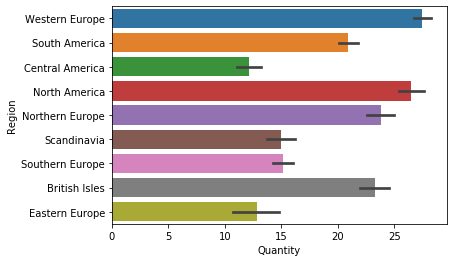

In [86]:
# View barplot to see if the categories are statistically different and compare standard error of the mean.
# Discounted products sold in larger quantities.

sns.barplot(data=df_Region, x='Quantity', y='Region', ci=68 )

### Check for outliers.

In [87]:
# Create 'grps' dictionary to seperate 'countries' by 'quantity'.
grps = {}
for grp_name in df_Region['Region'].unique():
    grps[grp_name] = df_Region.groupby('Region').get_group(grp_name)['Quantity']
grps

{'Western Europe': 0       12
 1       10
 2        5
 3       20
 4        7
         ..
 2073     6
 2074     7
 2075     5
 2076     6
 2077    10
 Name: Quantity, Length: 736, dtype: int64, 'South America': 24      10
 25      35
 26      15
 27      20
 28      42
         ..
 1955    10
 1956     8
 1957    20
 1958    10
 1959    20
 Name: Quantity, Length: 304, dtype: int64, 'Central America': 338     10
 339      1
 791     15
 792     10
 793     12
 794     10
 795      5
 796      6
 797     30
 798     10
 799      2
 800      8
 801     14
 802     30
 803      5
 804     15
 805      9
 806     10
 807     20
 808     21
 809      2
 810      7
 811     21
 812     15
 813      5
 814     20
 815     12
 816     10
 817     30
 818     10
 819     20
 1209     1
 1210     5
 1211     3
 1212     5
 1213    10
 1214    10
 1215     2
 1216    10
 1217     7
 1218    10
 1249    20
 1250    12
 1251     4
 1252    12
 1253    18
 1254    21
 1255    10
 1256    21
 1257   

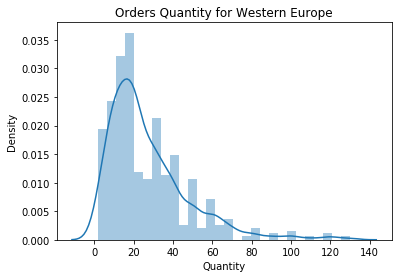

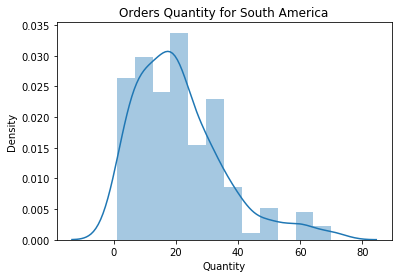

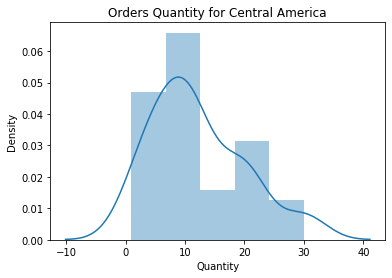

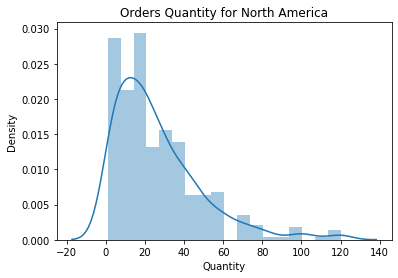

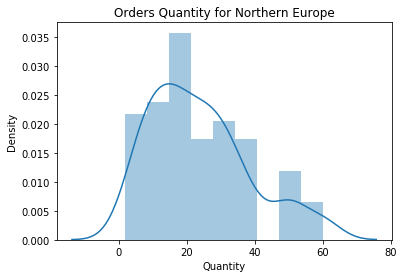

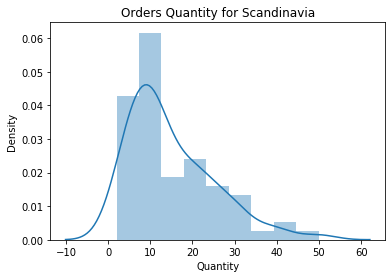

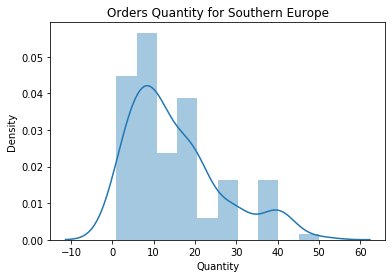

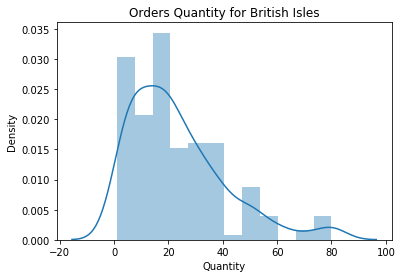

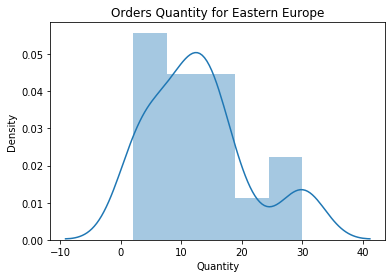

In [88]:
# Show Distribution Plot of Discounted group to determine if normailty assumption is met.
for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Orders Quantity for {grp_name}', ylabel='Density')

In [89]:
orig_grps = grps.copy()

In [90]:
# Identify how many outliers found in each group using Z-Scores.

for grp_name, grp_data in grps.items():
    idx_outs =find_outliers_Z(grp_data)
    print(f"Found {idx_outs.sum()} outliers in {grp_name} using Z-scores")
    grps[grp_name] = grp_data [~idx_outs]
    idx_outs =find_outliers_IQR(grp_data)

Found 14 outliers in Western Europe using Z-scores
Found 4 outliers in South America using Z-scores
Found 0 outliers in Central America using Z-scores
Found 10 outliers in North America using Z-scores
Found 0 outliers in Northern Europe using Z-scores
Found 1 outliers in Scandinavia using Z-scores
Found 1 outliers in Southern Europe using Z-scores
Found 5 outliers in British Isles using Z-scores
Found 0 outliers in Eastern Europe using Z-scores


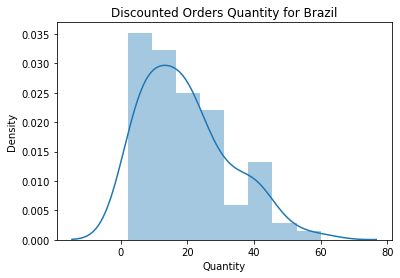

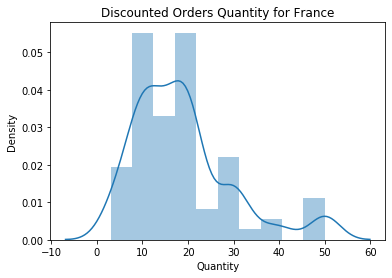

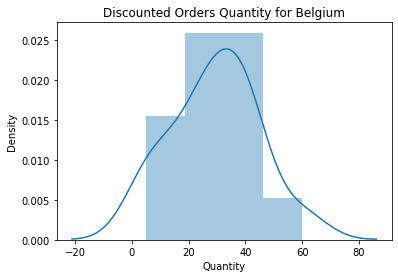

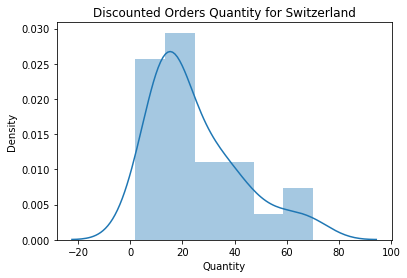

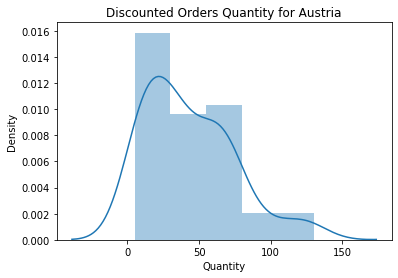

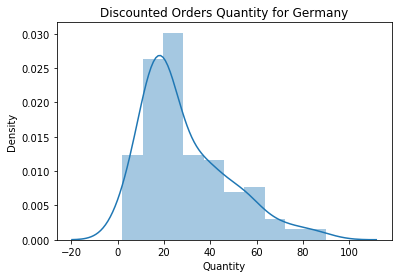

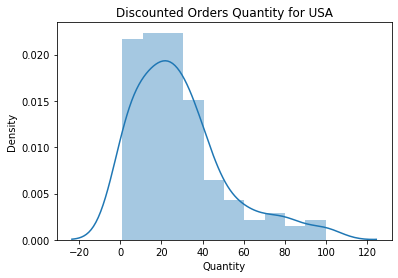

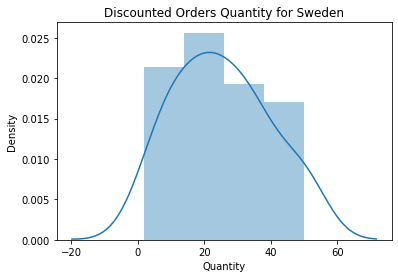

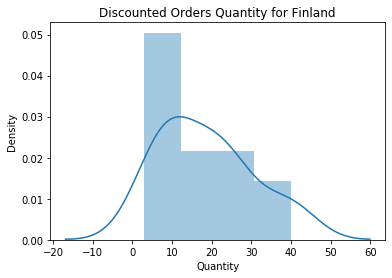

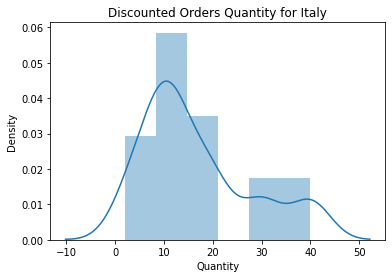

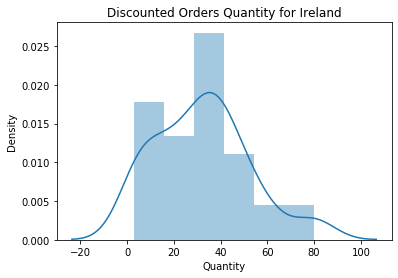

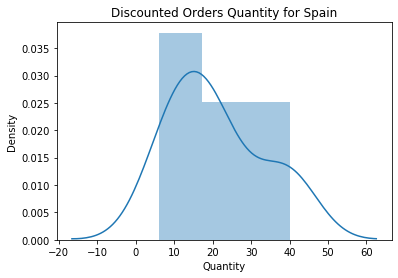

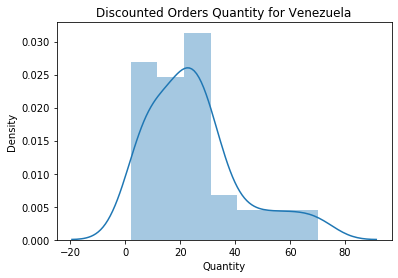

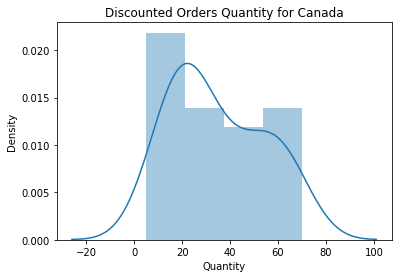

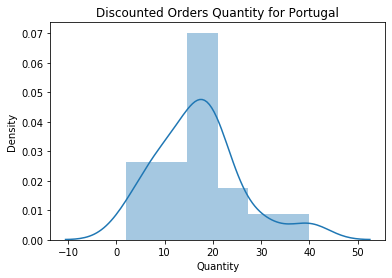

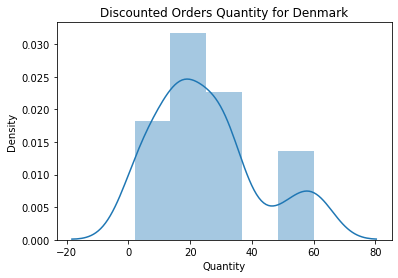

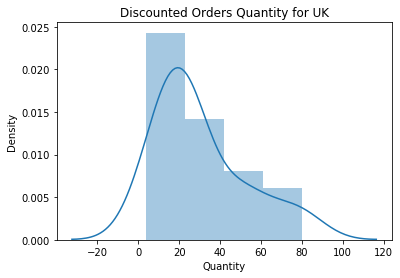

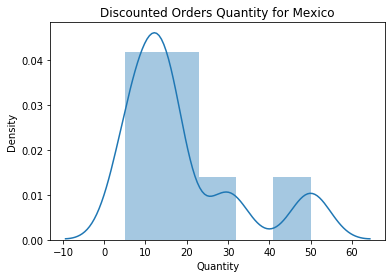

In [51]:
# Show Distribution Plot of Discounted group to determine if normailty assumption is met.
for grp_name,grp_data in grps.items():
    fig,ax =plt.subplots()
    sns.distplot(grp_data,label=grp_name, ax=ax)
    ax.set(title=f'Discounted Orders Quantity for {grp_name}', ylabel='Density')

### Confirm normality with scipy normal test.

In [91]:
import scipy.stats as stats

In [92]:
for k,v in grps.items():
    stat,p = stats.normaltest(v)
    print(f"Group {k} Normaltest p-value = {round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'
    print(f"\t-The data is {sig} normal.")
    print(f"Group {k} sample size = {len(v)}")
    size = 'CAN' if len(v)>20 else 'CAN NOT'
    print(f"\t-Normality assumption {size} be ignored.")
    print('\n')

Group Western Europe Normaltest p-value = 0.0
	-The data is is NOT normal.
Group Western Europe sample size = 722
	-Normality assumption CAN be ignored.


Group South America Normaltest p-value = 0.0
	-The data is is NOT normal.
Group South America sample size = 300
	-Normality assumption CAN be ignored.


Group Central America Normaltest p-value = 0.0733
	-The data is IS normal.
Group Central America sample size = 55
	-Normality assumption CAN be ignored.


Group North America Normaltest p-value = 0.0
	-The data is is NOT normal.
Group North America sample size = 417
	-Normality assumption CAN be ignored.


Group Northern Europe Normaltest p-value = 0.0019
	-The data is is NOT normal.
Group Northern Europe sample size = 143
	-Normality assumption CAN be ignored.


Group Scandinavia Normaltest p-value = 0.011
	-The data is is NOT normal.
Group Scandinavia sample size = 69
	-Normality assumption CAN be ignored.


Group Southern Europe Normaltest p-value = 0.0001
	-The data is is NOT nor

/Users/srn/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



In [19]:
# Failed normality testand sample sizes are not large enough to bypass normality assumption.


In [93]:
# Prepare data for  to check for equal variance.

data = []
for k,v in grps.items():
    data.append(v)
data[0]

0       12
1       10
2        5
3       20
4        7
        ..
2073     6
2074     7
2075     5
2076     6
2077    10
Name: Quantity, Length: 722, dtype: int64

In [94]:
stats.kruskal(*data)

KruskalResult(statistic=120.19176201723651, pvalue=3.0264098961747344e-22)

In [ ]:
# Kruskal test result is p-value is less than .05, null hypothesis is rejected. 

In [95]:
import functions as fn
data = fn.prep_data_for_tukeys(grps)
data

,data,group
0,12.0,Western Europe
1,10.0,Western Europe
2,5.0,Western Europe
3,20.0,Western Europe
4,7.0,Western Europe
...,...,...
1755,12.0,Eastern Europe
1756,7.0,Eastern Europe
1757,20.0,Eastern Europe
1758,30.0,Eastern Europe


In [96]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model = pairwise_tukeyhsd(data['data'],data['group'])
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
British Isles,Central America,-9.6531,0.0028,-17.2819,-2.0242,True
British Isles,Eastern Europe,-8.9497,0.4444,-21.8938,3.9945,False
British Isles,North America,2.7558,0.5674,-1.6322,7.1438,False
British Isles,Northern Europe,2.049,0.9,-3.482,7.58,False
British Isles,Scandinavia,-7.3274,0.0324,-14.3343,-0.3205,True
British Isles,South America,-1.4988,0.9,-6.1423,3.1447,False
British Isles,Southern Europe,-6.8872,0.0045,-12.4979,-1.2765,True
British Isles,Western Europe,4.0966,0.0496,0.0033,8.1898,True
Central America,Eastern Europe,0.7034,0.9,-13.406,14.8128,False
Central America,North America,12.4089,0.001,5.283,19.5348,True


In [97]:
df = pd.DataFrame(data=model._results_table.data[1:], columns=model._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,British Isles,Central America,-9.6531,0.0028,-17.2819,-2.0242,True
1,British Isles,Eastern Europe,-8.9497,0.4444,-21.8938,3.9945,False
2,British Isles,North America,2.7558,0.5674,-1.6322,7.1438,False
3,British Isles,Northern Europe,2.0490,0.9000,-3.4820,7.5800,False
4,British Isles,Scandinavia,-7.3274,0.0324,-14.3343,-0.3205,True
5,British Isles,South America,-1.4988,0.9000,-6.1423,3.1447,False
6,British Isles,Southern Europe,-6.8872,0.0045,-12.4979,-1.2765,True
7,British Isles,Western Europe,4.0966,0.0496,0.0033,8.1898,True
8,Central America,Eastern Europe,0.7034,0.9000,-13.4060,14.8128,False
9,Central America,North America,12.4089,0.0010,5.2830,19.5348,True


In [101]:
df_grp12p = df[df['reject'] == True][['group1', 'group2','p-adj']]
df_grp12p.reset_index(drop=True, inplace= True)
df_grp12p

,group1,group2,p-adj
0,British Isles,Central America,0.0028
1,British Isles,Scandinavia,0.0324
2,British Isles,Southern Europe,0.0045
3,British Isles,Western Europe,0.0496
4,Central America,North America,0.0010
5,Central America,Northern Europe,0.0010
6,Central America,South America,0.0153
7,Central America,Western Europe,0.0010
8,Eastern Europe,Western Europe,0.0346
9,North America,Scandinavia,0.0010


In [99]:
df_grp12p.to_csv("regionpvalues.csv")

In [100]:
pd.set_option("display.max_rows",999)

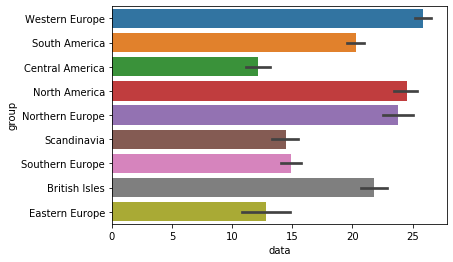

In [102]:
sns.barplot(data=data ,x='data',y='group',ci=68)

# Conclusion

The null hypothesis is rejected. Order quantities of different regions are not the same.